# Previous Bit Task

### This task involves the model taking in an 1d array of 0s and 1s. The model should output a 1 the timestep after a 1 is detected in a the input.
### Ex:
### Input: [0 1 0 0 0 1 0]
### Output:[0 0 1 0 0 0 1]

In [1]:
from Training.generator_prevbit import make_train_test
import numpy as np
from SSM.hippo import hippo_legs, discretize_bilinear
from SSM.helpers import sigmoid, binary_cross_entropy
from SSM.model import SimpleSSM
import matplotlib.pyplot as plt

In [2]:
# Generate data

# Size of data matters alot, especially for how simple the task is. If the training data is very large, then the model will learn it within one epoch and the average loss will be small even on the first pass
x_train, y_train, x_test, y_test = make_train_test(
    n_train=100,
    n_test=10,
    T=10,
    seed=0,
)

In [3]:
model = SimpleSSM(state_dim=8, input_dim=1, output_dim=1)
num_epochs = 10
learning_rate = 1e-2

In [4]:
from SSM.helpers import sigmoid  # or your sigmoid

u = x_train[0]            # (T,1)
t = y_train[0]            # (T,1)
logits, _ = model.forward(u)
probs = sigmoid(logits)

eps = 1e-8
loss_manual = -np.mean(
    t * np.log(probs + eps) +
    (1 - t) * np.log(1 - probs + eps)
)
print("manual BCE on first sequence:", loss_manual)

loss, _ = model.loss_and_grads(u, t)
print("loss_and_grads loss:", loss)


manual BCE on first sequence: 0.693127495054777
loss_and_grads loss: 0.693127495054777


In [5]:
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i in range(x_train.shape[0]):
        u = x_train[i]      # shape (T,1)
        tgt = y_train[i]    # shape (T,1)

        loss, grads = model.loss_and_grads(u, tgt)
        

        
        model.step(grads, lr=learning_rate)
        epoch_loss += loss

    print(f"epoch {epoch} | avg loss = {epoch_loss / x_train.shape[0]}")

epoch 0 | avg loss = 0.6879106509364754
epoch 1 | avg loss = 0.683121272966656
epoch 2 | avg loss = 0.6769088588642727
epoch 3 | avg loss = 0.6684853640239835
epoch 4 | avg loss = 0.6570768769677479
epoch 5 | avg loss = 0.6420406052729862
epoch 6 | avg loss = 0.6220244264588835
epoch 7 | avg loss = 0.5932047998161526
epoch 8 | avg loss = 0.5497263027419215
epoch 9 | avg loss = 0.4878240095192452


In [6]:
# Testing ERror
print("mean of y_train:", y_train.mean())
print("min target:", y_train.min(), "max target:", y_train.max())
print("mean target over all train data:", y_train.mean())

u = x_train[0].reshape(-1)
t = y_train[0].reshape(-1)
print("input:  ", u.astype(int).tolist())
print("target: ", t.astype(int).tolist())

import numpy as np
eps = 1e-8
p = 0.01
y = y_train.reshape(-1)   # flatten all targets

baseline_loss = -np.mean(
    y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)
)

print("baseline constant-p loss:", baseline_loss)

mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
baseline constant-p loss: 2.4408682028173887


In [7]:
N = x_test.shape[0]
total_loss = 0.0
total_correct = 0
total_bits = 0

for i in range(N):
    u = x_test[i]      # (T, 1)
    tgt = y_test[i]    # (T, 1)

    # forward pass only (no grads)
    logits, _ = model.forward(u)

    # loss for this sequence
    loss = binary_cross_entropy(logits, tgt)
    total_loss += loss

    # compute accuracy for this sequence
    probs = sigmoid(logits)
    preds = (probs > 0.5).astype(int)   # threshold at 0.5
    total_correct += (preds == tgt).sum()
    total_bits += tgt.size

avg_loss = total_loss / N
accuracy = total_correct / total_bits

print(avg_loss)
print(accuracy)

0.44985656218869013
0.92


Test loss: 0.4499


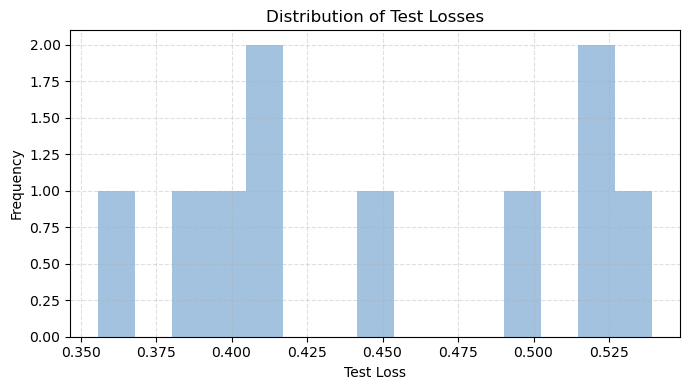

In [8]:
# evaluate model on test data
test_loss = 0
test_losses = []

for i in range(num_epochs):
    u = x_test[i]
    target = y_test[i]
    loss,_ = model.loss_and_grads(u, target)    # only need loss
    # print(loss)
    test_losses.append(loss)
    test_loss += loss

print(f'Test loss: {test_loss / num_epochs:.4f}')

plt.figure(figsize=(7, 4))
plt.hist(test_losses, bins=15, color="#A2C2E0")
plt.title("Distribution of Test Losses")
plt.xlabel("Test Loss")
plt.ylabel("Frequency")
plt.grid(alpha=0.4, linestyle='--')
plt.tight_layout()
plt.show()